# Cellule 1: Imports et Configuration

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, defaultdict
import seaborn as sns
from IPython.display import HTML, clear_output
from matplotlib.animation import FuncAnimation
import time

# Configuration
EPISODES = 1000
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
MEMORY_SIZE = 10000
BATCH_SIZE = 32
TARGET_UPDATE = 10

print("Configuration chargée!")
print(f"Épisodes d'entraînement: {EPISODES}")
print(f"Taux d'apprentissage: {LEARNING_RATE}")
print(f"Facteur de discount: {GAMMA}")

Configuration chargée!
Épisodes d'entraînement: 1000
Taux d'apprentissage: 0.001
Facteur de discount: 0.99


# Cellule 2: Classes des Réseaux et Buffer

In [2]:
class DQNNetwork(nn.Module):
    """Réseau de neurones pour DQN"""
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    """Buffer de replay pour stocker les expériences"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

print("Classes des réseaux et buffer définies!")

Classes des réseaux et buffer définies!


# Cellule 3: Agent DQN


In [3]:
class DQNAgent:
    """Agent DQN (Deep Q-Network)"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON_START
        
        # Réseaux principal et cible
        self.q_network = DQNNetwork(state_size, action_size)
        self.target_network = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LEARNING_RATE)
        
        # Buffer de replay
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Sauvegarder l'expérience dans le buffer
        self.memory.push(state, action, reward, next_state, done)
        
        # Apprendre tous les TARGET_UPDATE pas de temps
        self.t_step = (self.t_step + 1) % TARGET_UPDATE
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences)
    
    def act(self, state, eps=None):
        if eps is None:
            eps = self.epsilon
            
        if random.random() > eps:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state)
            return np.argmax(q_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences):
        states = torch.FloatTensor([e[0] for e in experiences])
        actions = torch.LongTensor([e[1] for e in experiences])
        rewards = torch.FloatTensor([e[2] for e in experiences])
        next_states = torch.FloatTensor([e[3] for e in experiences])
        dones = torch.BoolTensor([e[4] for e in experiences])
        
        # Q-values actuelles
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Q-values suivantes du réseau cible
        next_q_values = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_values = rewards.unsqueeze(1) + (GAMMA * next_q_values * ~dones.unsqueeze(1))
        
        # Calcul de la perte
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimisation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Mise à jour du réseau cible
        self.soft_update()
        
        # Diminution d'epsilon
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY
    
    def soft_update(self, tau=0.001):
        """Mise à jour douce du réseau cible"""
        for target_param, local_param in zip(self.target_network.parameters(), 
                                           self.q_network.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

print("Agent DQN défini!")

Agent DQN défini!


# Cellule 4: Agents Tabulaires (SARSA, Monte Carlo, Q-Learning)

In [4]:
class SARSAAgent:
    """Agent SARSA (State-Action-Reward-State-Action) tabulaire"""
    def __init__(self, state_size, action_size, bins=15):
        self.action_size = action_size
        self.epsilon = EPSILON_START
        self.alpha = 0.1  # Taux d'apprentissage
        self.bins = bins
        
        # Table Q discrétisée
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        
        # Bornes pour la discrétisation (spécifiques à CartPole)
        self.state_bounds = [
            [-2.4, 2.4],      # Position du cart
            [-3.0, 3.0],      # Vitesse du cart
            [-0.21, 0.21],    # Angle du pole
            [-2.0, 2.0]       # Vitesse angulaire du pole
        ]
        
        # Variables pour SARSA
        self.last_state = None
        self.last_action = None
    
    def discretize_state(self, state):
        """Discrétise l'état continu"""
        discrete_state = []
        for i, s in enumerate(state):
            # Clamper la valeur dans les bornes
            s = max(self.state_bounds[i][0], min(s, self.state_bounds[i][1]))
            # Discrétiser
            discrete = int((s - self.state_bounds[i][0]) / 
                          (self.state_bounds[i][1] - self.state_bounds[i][0]) * (self.bins - 1))
            discrete_state.append(discrete)
        return tuple(discrete_state)
    
    def act(self, state, eps=None):
        if eps is None:
            eps = self.epsilon
            
        discrete_state = self.discretize_state(state)
        
        if random.random() > eps:
            action = np.argmax(self.q_table[discrete_state])
        else:
            action = random.choice(range(self.action_size))
        
        # Stocker pour SARSA
        self.last_state = discrete_state
        self.last_action = action
        return action
    
    def step(self, state, action, reward, next_state, done):
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        # SARSA: on a besoin de la prochaine action
        if done:
            next_action_value = 0
        else:
            # Choisir la prochaine action selon la politique
            if random.random() > self.epsilon:
                next_action = np.argmax(self.q_table[discrete_next_state])
            else:
                next_action = random.choice(range(self.action_size))
            next_action_value = self.q_table[discrete_next_state][next_action]
        
        # Mise à jour SARSA
        target = reward + GAMMA * next_action_value
        self.q_table[discrete_state][action] += self.alpha * (
            target - self.q_table[discrete_state][action]
        )
        
        # Diminution d'epsilon
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

class MonteCarloAgent:
    """Agent Monte Carlo (First-Visit)"""
    def __init__(self, state_size, action_size, bins=12):
        self.action_size = action_size
        self.epsilon = EPSILON_START
        self.bins = bins
        
        # Table Q et compteurs pour MC
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.returns = defaultdict(lambda: defaultdict(list))
        
        # Épisode actuel
        self.episode_data = []
        
        # Bornes pour la discrétisation
        self.state_bounds = [
            [-2.4, 2.4],      # Position du cart
            [-3.0, 3.0],      # Vitesse du cart
            [-0.21, 0.21],    # Angle du pole
            [-2.0, 2.0]       # Vitesse angulaire du pole
        ]
    
    def discretize_state(self, state):
        """Discrétise l'état continu"""
        discrete_state = []
        for i, s in enumerate(state):
            s = max(self.state_bounds[i][0], min(s, self.state_bounds[i][1]))
            discrete = int((s - self.state_bounds[i][0]) / 
                          (self.state_bounds[i][1] - self.state_bounds[i][0]) * (self.bins - 1))
            discrete_state.append(discrete)
        return tuple(discrete_state)
    
    def act(self, state, eps=None):
        if eps is None:
            eps = self.epsilon
            
        discrete_state = self.discretize_state(state)
        
        if random.random() > eps:
            return np.argmax(self.q_table[discrete_state])
        else:
            return random.choice(range(self.action_size))
    
    def step(self, state, action, reward, next_state, done):
        discrete_state = self.discretize_state(state)
        
        # Stocker l'expérience de l'épisode
        self.episode_data.append((discrete_state, action, reward))
        
        # Si l'épisode est terminé, faire la mise à jour Monte Carlo
        if done:
            self.update_q_values()
            self.episode_data = []  # Reset pour le prochain épisode
            
            # Diminution d'epsilon
            if self.epsilon > EPSILON_END:
                self.epsilon *= EPSILON_DECAY
    
    def update_q_values(self):
        """Mise à jour Monte Carlo First-Visit"""
        G = 0  # Retour cumulé
        visited_state_actions = set()
        
        # Parcourir l'épisode à l'envers
        for i in reversed(range(len(self.episode_data))):
            state, action, reward = self.episode_data[i]
            G = GAMMA * G + reward
            
            # First-visit Monte Carlo
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                self.returns[state][action].append(G)
                # Mise à jour de Q(s,a) = moyenne des retours
                self.q_table[state][action] = np.mean(self.returns[state][action])

class TabularQAgent:
    """Agent Q-learning tabulaire (avec discrétisation)"""
    def __init__(self, state_size, action_size, bins=20):
        self.action_size = action_size
        self.epsilon = EPSILON_START
        self.alpha = 0.1  # Taux d'apprentissage
        self.bins = bins
        
        # Table Q discrétisée
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        
        # Bornes pour la discrétisation (spécifiques à CartPole)
        self.state_bounds = [
            [-2.4, 2.4],      # Position du cart
            [-3.0, 3.0],      # Vitesse du cart
            [-0.21, 0.21],    # Angle du pole
            [-2.0, 2.0]       # Vitesse angulaire du pole
        ]
    
    def discretize_state(self, state):
        """Discrétise l'état continu"""
        discrete_state = []
        for i, s in enumerate(state):
            # Clamper la valeur dans les bornes
            s = max(self.state_bounds[i][0], min(s, self.state_bounds[i][1]))
            # Discrétiser
            discrete = int((s - self.state_bounds[i][0]) / 
                          (self.state_bounds[i][1] - self.state_bounds[i][0]) * (self.bins - 1))
            discrete_state.append(discrete)
        return tuple(discrete_state)
    
    def act(self, state, eps=None):
        if eps is None:
            eps = self.epsilon
            
        discrete_state = self.discretize_state(state)
        
        if random.random() > eps:
            return np.argmax(self.q_table[discrete_state])
        else:
            return random.choice(range(self.action_size))
    
    def step(self, state, action, reward, next_state, done):
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        
        # Mise à jour Q-learning
        if done:
            target = reward
        else:
            target = reward + GAMMA * np.max(self.q_table[discrete_next_state])
        
        self.q_table[discrete_state][action] += self.alpha * (
            target - self.q_table[discrete_state][action]
        )
        
        # Diminution d'epsilon
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

print("Agents tabulaires définis!")

Agents tabulaires définis!


# Cellule 5: Agent Policy Gradient

In [5]:
class PolicyGradientAgent:
    """Agent Policy Gradient (REINFORCE) simplifié"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Réseau de politique
        self.policy_network = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
            nn.Softmax(dim=-1)
        )
        
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=0.01)
        
        # Stockage de l'épisode
        self.episode_states = []
        self.episode_actions = []
        self.episode_rewards = []
    
    def act(self, state, eps=None):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy_network(state)
        
        # Échantillonner selon la distribution de probabilité
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        
        # Stocker pour l'apprentissage
        self.episode_states.append(state)
        self.episode_actions.append(action)
        
        return action.item()
    
    def step(self, state, action, reward, next_state, done):
        # Stocker la récompense
        self.episode_rewards.append(reward)
        
        # Si l'épisode est terminé, faire la mise à jour
        if done:
            self.update_policy()
            # Reset pour le prochain épisode
            self.episode_states = []
            self.episode_actions = []
            self.episode_rewards = []
    
    def update_policy(self):
        """Mise à jour REINFORCE"""
        if len(self.episode_rewards) == 0:
            return
            
        # Calculer les retours actualisés
        returns = []
        G = 0
        for reward in reversed(self.episode_rewards):
            G = reward + GAMMA * G
            returns.insert(0, G)
        
        # Normaliser les retours
        returns = torch.FloatTensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Calculer la perte de politique
        policy_loss = []
        for i in range(len(self.episode_states)):
            state = self.episode_states[i]
            action = self.episode_actions[i]
            G = returns[i]
            
            # Probabilité de l'action prise
            probs = self.policy_network(state)
            action_prob = probs[0][action]
            
            # Perte REINFORCE: -log(π(a|s)) * G
            policy_loss.append(-torch.log(action_prob) * G)
        
        # Optimisation
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

print("Agent Policy Gradient défini!")

Agent Policy Gradient défini!


# Cellule 6: Fonctions de Visualisation CartPole

In [6]:
def visualize_cartpole_episode(agent, env, title="CartPole Visualization", max_steps=500):
    """Visualise un épisode de CartPole en temps réel"""
    
    # Enregistrer les données de l'épisode
    states = []
    actions = []
    rewards = []
    
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    total_reward = 0
    step_count = 0
    
    while step_count < max_steps:
        # Choisir l'action (pas d'exploration pour la démo)
        action = agent.act(state, eps=0.0)
        
        # Exécuter l'action
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, info = step_result
            truncated = False
        else:
            next_state, reward, done, truncated, info = step_result
        
        done = done or truncated
        
        # Stocker les données
        states.append(state.copy())
        actions.append(action)
        rewards.append(reward)
        
        total_reward += reward
        step_count += 1
        
        state = next_state
        
        if done:
            break
    
    # Créer la visualisation
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{title} - Score: {total_reward:.0f} - Steps: {step_count}', fontsize=16)
    
    # Convertir les états en arrays
    states = np.array(states)
    
    # Graphique 1: Position du cart
    ax1.plot(states[:, 0], 'b-', linewidth=2)
    ax1.set_title('Position du Cart')
    ax1.set_xlabel('Étapes')
    ax1.set_ylabel('Position')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=2.4, color='r', linestyle='--', alpha=0.7, label='Limite')
    ax1.axhline(y=-2.4, color='r', linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Graphique 2: Angle du pole
    ax2.plot(np.degrees(states[:, 2]), 'g-', linewidth=2)
    ax2.set_title('Angle du Pole (degrés)')
    ax2.set_xlabel('Étapes')
    ax2.set_ylabel('Angle')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=12, color='r', linestyle='--', alpha=0.7, label='Limite (~12°)')
    ax2.axhline(y=-12, color='r', linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Graphique 3: Vitesses
    ax3.plot(states[:, 1], 'b-', linewidth=2, label='Vitesse Cart')
    ax3.plot(states[:, 3], 'r-', linewidth=2, label='Vitesse angulaire Pole')
    ax3.set_title('Vitesses')
    ax3.set_xlabel('Étapes')
    ax3.set_ylabel('Vitesse')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Graphique 4: Actions
    ax4.bar(range(len(actions)), actions, alpha=0.7, 
           color=['blue' if a == 0 else 'red' for a in actions])
    ax4.set_title('Actions (0=Gauche, 1=Droite)')
    ax4.set_xlabel('Étapes')
    ax4.set_ylabel('Action')
    ax4.set_ylim(-0.5, 1.5)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return total_reward, step_count

def create_cartpole_animation(agent, env, title="CartPole Animation", max_steps=200):
    """Crée une animation de CartPole"""
    
    # Simuler l'épisode
    states = []
    actions = []
    
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    step_count = 0
    total_reward = 0
    
    while step_count < max_steps:
        action = agent.act(state, eps=0.0)
        
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, info = step_result
            truncated = False
        else:
            next_state, reward, done, truncated, info = step_result
        
        done = done or truncated
        
        states.append(state.copy())
        actions.append(action)
        
        total_reward += reward
        step_count += 1
        
        state = next_state
        
        if done:
            break
    
    # Créer l'animation
    fig, ax = plt.subplots(figsize=(10, 6))
    
    def animate(frame):
        ax.clear()
        
        if frame >= len(states):
            return
            
        state = states[frame]
        action = actions[frame] if frame < len(actions) else 0
        
        # Position du cart
        cart_x = state[0]
        cart_y = 0
        
        # Position du pole
        pole_length = 1.0
        pole_angle = state[2]  # angle en radians
        pole_x = cart_x + pole_length * np.sin(pole_angle)
        pole_y = cart_y + pole_length * np.cos(pole_angle)
        
        # Dessiner le cart (rectangle)
        cart_width = 0.3
        cart_height = 0.2
        cart_rect = plt.Rectangle((cart_x - cart_width/2, cart_y - cart_height/2), 
                                 cart_width, cart_height, 
                                 color='blue', alpha=0.8)
        ax.add_patch(cart_rect)
        
        # Dessiner le pole (ligne)
        ax.plot([cart_x, pole_x], [cart_y, pole_y], 'r-', linewidth=4)
        
        # Dessiner le pivot
        ax.plot(cart_x, cart_y, 'ko', markersize=8)
        
        # Dessiner la masse du pole
        ax.plot(pole_x, pole_y, 'ro', markersize=10)
        
        # Flèche pour indiquer l'action
        if action == 1:  # Droite
            ax.arrow(cart_x + 0.2, cart_y, 0.3, 0, head_width=0.05, 
                    head_length=0.1, fc='green', ec='green')
        else:  # Gauche
            ax.arrow(cart_x - 0.2, cart_y, -0.3, 0, head_width=0.05, 
                    head_length=0.1, fc='orange', ec='orange')
        
        # Configuration de l'affichage
        ax.set_xlim(-3, 3)
        ax.set_ylim(-0.5, 1.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{title} - Step: {frame+1}/{len(states)} - Score: {total_reward:.0f}')
        
        # Ligne de base
        ax.axhline(y=0, color='black', linewidth=2)
        
        # Limites de position
        ax.axvline(x=2.4, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=-2.4, color='red', linestyle='--', alpha=0.5)
    
    # Créer et retourner l'animation
    anim = FuncAnimation(fig, animate, frames=len(states), interval=50, repeat=True)
    plt.show()
    
    return anim, total_reward, step_count

print("Fonctions de visualisation définies!")

Fonctions de visualisation définies!


# Cellule 7: Fonctions d'Entraînement et Évaluation

In [7]:
def train_agent(agent, env, episodes, agent_name):
    """Entraîne un agent et retourne les scores"""
    scores = []
    scores_window = deque(maxlen=100)
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]  # Pour gym>=0.26
        score = 0
        
        while True:
            action = agent.act(state)
            
            # Compatibilité avec différentes versions de gym
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, info = step_result
                truncated = False
            else:
                next_state, reward, done, truncated, info = step_result
            
            done = done or truncated
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        
        if episode % 100 == 0:
            print(f'{agent_name} - Episode {episode}, Average Score: {np.mean(scores_window):.2f}')
    
    return scores

def evaluate_agent(agent, env, episodes=100):
    """Évalue un agent entraîné"""
    scores = []
    
    for _ in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        score = 0
        
        while True:
            action = agent.act(state, eps=0.0)  # Pas d'exploration
            
            # Compatibilité avec différentes versions de gym
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, info = step_result
                truncated = False
            else:
                next_state, reward, done, truncated, info = step_result
            
            done = done or truncated
            state = next_state
            score += reward
            
            if done:
                break
        
        scores.append(score)
    
    return scores

def plot_training_results(results):
    """Visualise les résultats d'entraînement"""
    plt.figure(figsize=(15, 10))
    
    # Graphique 1: Scores d'entraînement
    plt.subplot(2, 2, 1)
    for agent_name, scores in results.items():
        # Moyenne mobile pour lisser les courbes
        window_size = 50
        smoothed_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_scores, label=agent_name, linewidth=2)
    
    plt.xlabel('Episode')
    plt.ylabel('Score (moyenne mobile)')
    plt.title('Performance d\'entraînement par algorithme')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Graphique 2: Scores moyens par algorithme
    plt.subplot(2, 2, 2)
    agent_names = list(results.keys())
    mean_scores = [np.mean(scores[-100:]) for scores in results.values()]  # Moyenne des 100 derniers épisodes
    
    colors = ['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#9B59B6']
    bars = plt.bar(agent_names, mean_scores, color=colors[:len(agent_names)])
    plt.ylabel('Score moyen (100 derniers épisodes)')
    plt.title('Performance moyenne finale')
    plt.xticks(rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, score in zip(bars, mean_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{score:.1f}', ha='center', va='bottom')
    
    # Graphique 3: Distribution des scores finaux
    plt.subplot(2, 2, 3)
    final_scores = [scores[-100:] for scores in results.values()]
    plt.boxplot(final_scores, labels=agent_names)
    plt.ylabel('Score')
    plt.title('Distribution des scores (100 derniers épisodes)')
    plt.xticks(rotation=45)
    
    # Graphique 4: Convergence
    plt.subplot(2, 2, 4)
    for agent_name, scores in results.items():
        # Calculer le nombre d'épisodes pour atteindre score >= 195
        convergence_episode = None
        window_size = 100
        for i in range(window_size, len(scores)):
            if np.mean(scores[i-window_size:i]) >= 195:
                convergence_episode = i
                break
        
        if convergence_episode:
            plt.bar(agent_name, convergence_episode, alpha=0.7)
            plt.text(agent_name, convergence_episode + 10, str(convergence_episode), 
                    ha='center', va='bottom')
    
    plt.ylabel('Épisodes pour convergence')
    plt.title('Vitesse de convergence (score ≥ 195)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

print("Fonctions d'entraînement et d'évaluation définies!")

Fonctions d'entraînement et d'évaluation définies!


# Cellule 8: Démonstration Agent Non-Entraîné

/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Environnement: CartPole-v1
Taille de l'espace d'état: 4
Nombre d'actions: 2
--------------------------------------------------
Démonstration d'un agent DQN NON-ENTRAÎNÉ:
L'agent choisit des actions aléatoirement...



/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


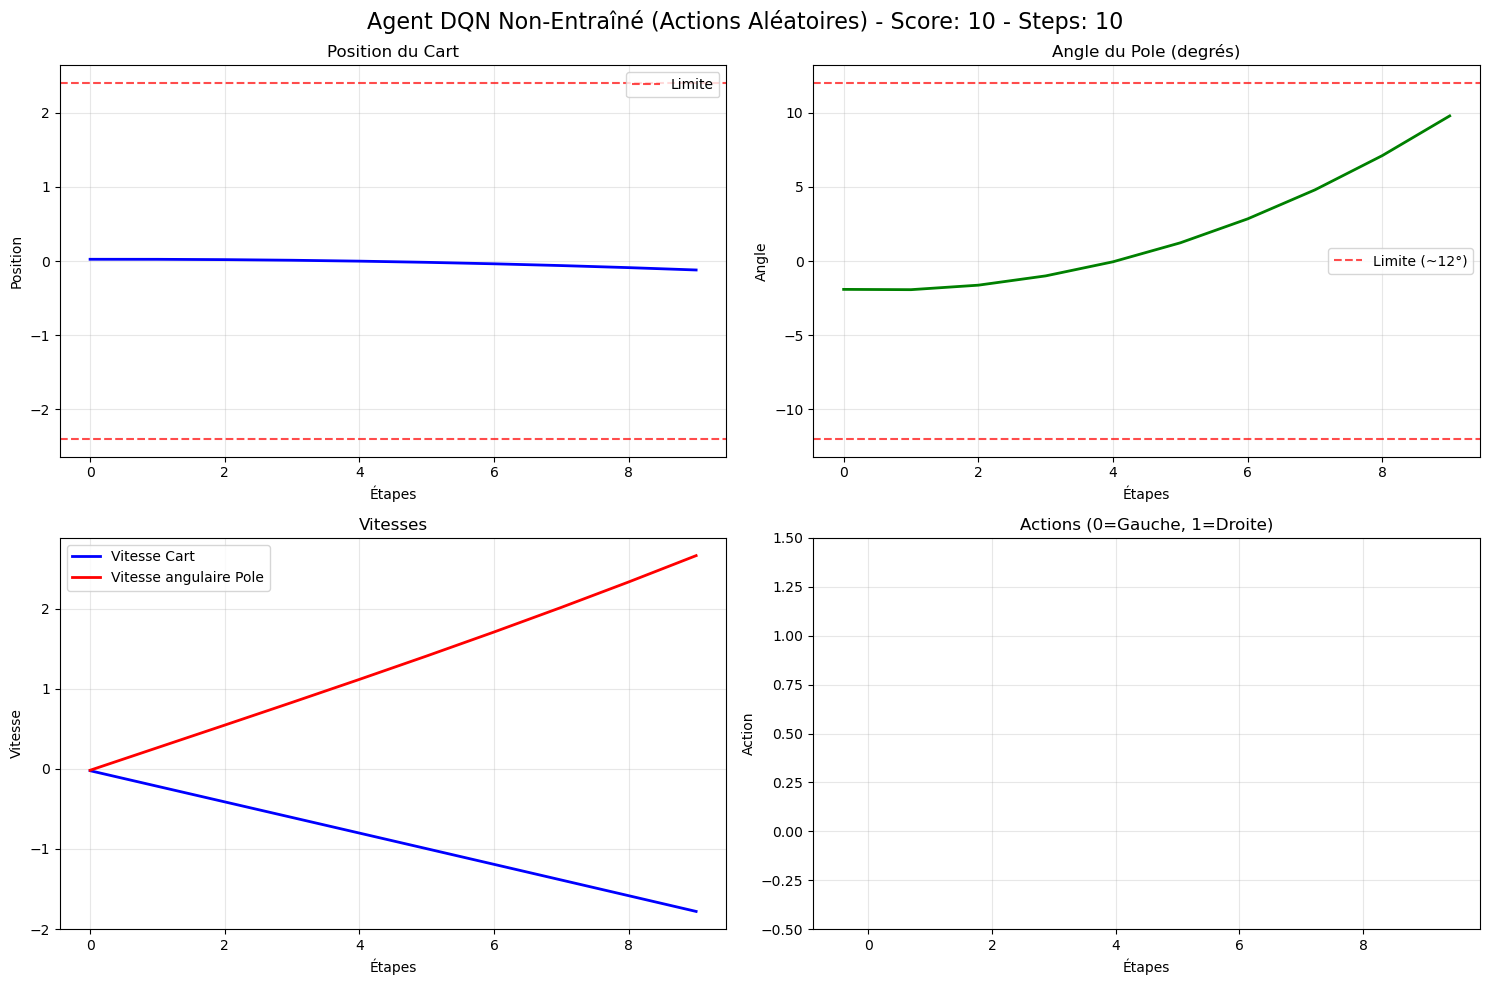

Performance avant entraînement:
- Score: 10.0
- Nombre d'étapes: 10

Création de l'animation de l'agent non-entraîné...


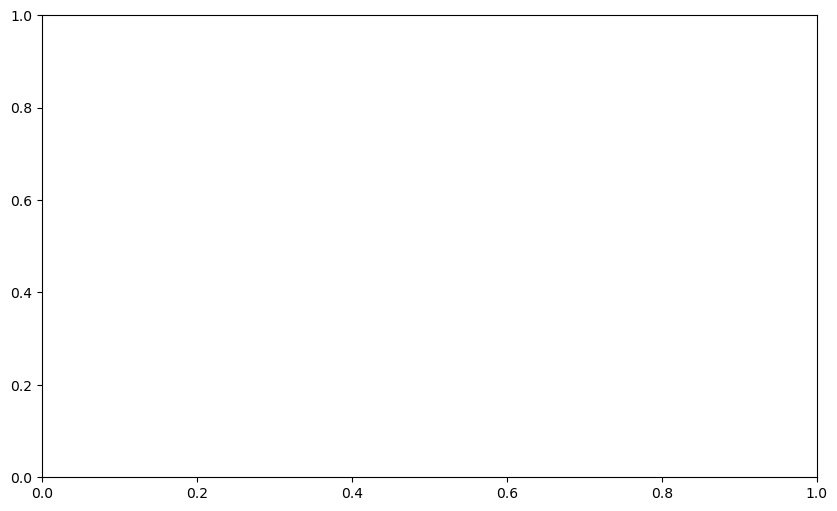

In [8]:
# Créer l'environnement
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"Environnement: CartPole-v1")
print(f"Taille de l'espace d'état: {state_size}")
print(f"Nombre d'actions: {action_size}")
print("-" * 50)

# Créer un agent DQN non-entraîné pour la démonstration
untrained_agent = DQNAgent(state_size, action_size)

print("Démonstration d'un agent DQN NON-ENTRAÎNÉ:")
print("L'agent choisit des actions aléatoirement...")
print()

# Visualiser la performance avant entraînement
score_before, steps_before = visualize_cartpole_episode(
    untrained_agent, env, 
    title="Agent DQN Non-Entraîné (Actions Aléatoires)"
)

print(f"Performance avant entraînement:")
print(f"- Score: {score_before}")
print(f"- Nombre d'étapes: {steps_before}")

# Animation de l'agent non-entraîné
print("\nCréation de l'animation de l'agent non-entraîné...")
anim_before, _, _ = create_cartpole_animation(
    untrained_agent, env, 
    title="Agent Non-Entraîné", 
    max_steps=100
)

In [ ]:
# Pour l'affichage direct
env_human = gym.make('CartPole-v1', render_mode='human')
env_human.reset()

# Pour la vidéo (animation avec matplotlib ou autre)
env_video = gym.make('CartPole-v1', render_mode='rgb_array')
env_video.reset()

/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([-0.03438483,  0.0289052 , -0.0203812 ,  0.01214742], dtype=float32)

: 

# Cellule 9: Entraînement des Agents

In [10]:
print("Initialisation des agents pour l'entraînement...")

# Initialiser les agents
agents = {
    'DQN': DQNAgent(state_size, action_size),
    'SARSA': SARSAAgent(state_size, action_size),
    'Monte Carlo': MonteCarloAgent(state_size, action_size),
    # 'Policy Gradient': PolicyGradientAgent(state_size, action_size),
    'Q-Learning Tabulaire': TabularQAgent(state_size, action_size)
}

print(f"Agents initialisés: {list(agents.keys())}")
print(f"Nombre d'épisodes d'entraînement: {EPISODES}")
print("-" * 60)

# Entraîner chaque agent
results = {}

for agent_name, agent in agents.items():
    print(f"\n Entraînement de {agent_name}...")
    start_time = time.time()
    
    scores = train_agent(agent, env, EPISODES, agent_name)
    results[agent_name] = scores
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Évaluation finale
    eval_scores = evaluate_agent(agent, env, episodes=100)
    mean_score = np.mean(eval_scores)
    std_score = np.std(eval_scores)
    
    print(f" {agent_name} terminé!")
    print(f"   Temps d'entraînement: {training_time:.1f}s")
    print(f"   Score moyen final: {mean_score:.2f} ± {std_score:.2f}")
    print(f"   Meilleur score: {np.max(eval_scores):.0f}")

print("\n" + "="*60)
print("🎉 ENTRAÎNEMENT TERMINÉ POUR TOUS LES AGENTS!")
print("="*60)

Initialisation des agents pour l'entraînement...
Agents initialisés: ['DQN', 'SARSA', 'Monte Carlo', 'Q-Learning Tabulaire']
Nombre d'épisodes d'entraînement: 1000
------------------------------------------------------------

 Entraînement de DQN...
DQN - Episode 0, Average Score: 10.00
DQN - Episode 100, Average Score: 18.73
DQN - Episode 200, Average Score: 11.68
DQN - Episode 300, Average Score: 10.19
DQN - Episode 400, Average Score: 10.87
DQN - Episode 500, Average Score: 10.40
DQN - Episode 600, Average Score: 9.83
DQN - Episode 700, Average Score: 10.11
DQN - Episode 800, Average Score: 10.47
DQN - Episode 900, Average Score: 10.48
 DQN terminé!
   Temps d'entraînement: 38.9s
   Score moyen final: 9.25 ± 0.70
   Meilleur score: 11

 Entraînement de SARSA...
SARSA - Episode 0, Average Score: 13.00
SARSA - Episode 100, Average Score: 25.15
SARSA - Episode 200, Average Score: 25.78
SARSA - Episode 300, Average Score: 25.39
SARSA - Episode 400, Average Score: 27.01
SARSA - Episode 5

# Cellule 10: Visualisation des Résultats d'Entraînement

Génération des graphiques de performance...


/tmp/ipykernel_16650/201582617.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(final_scores, labels=agent_names)


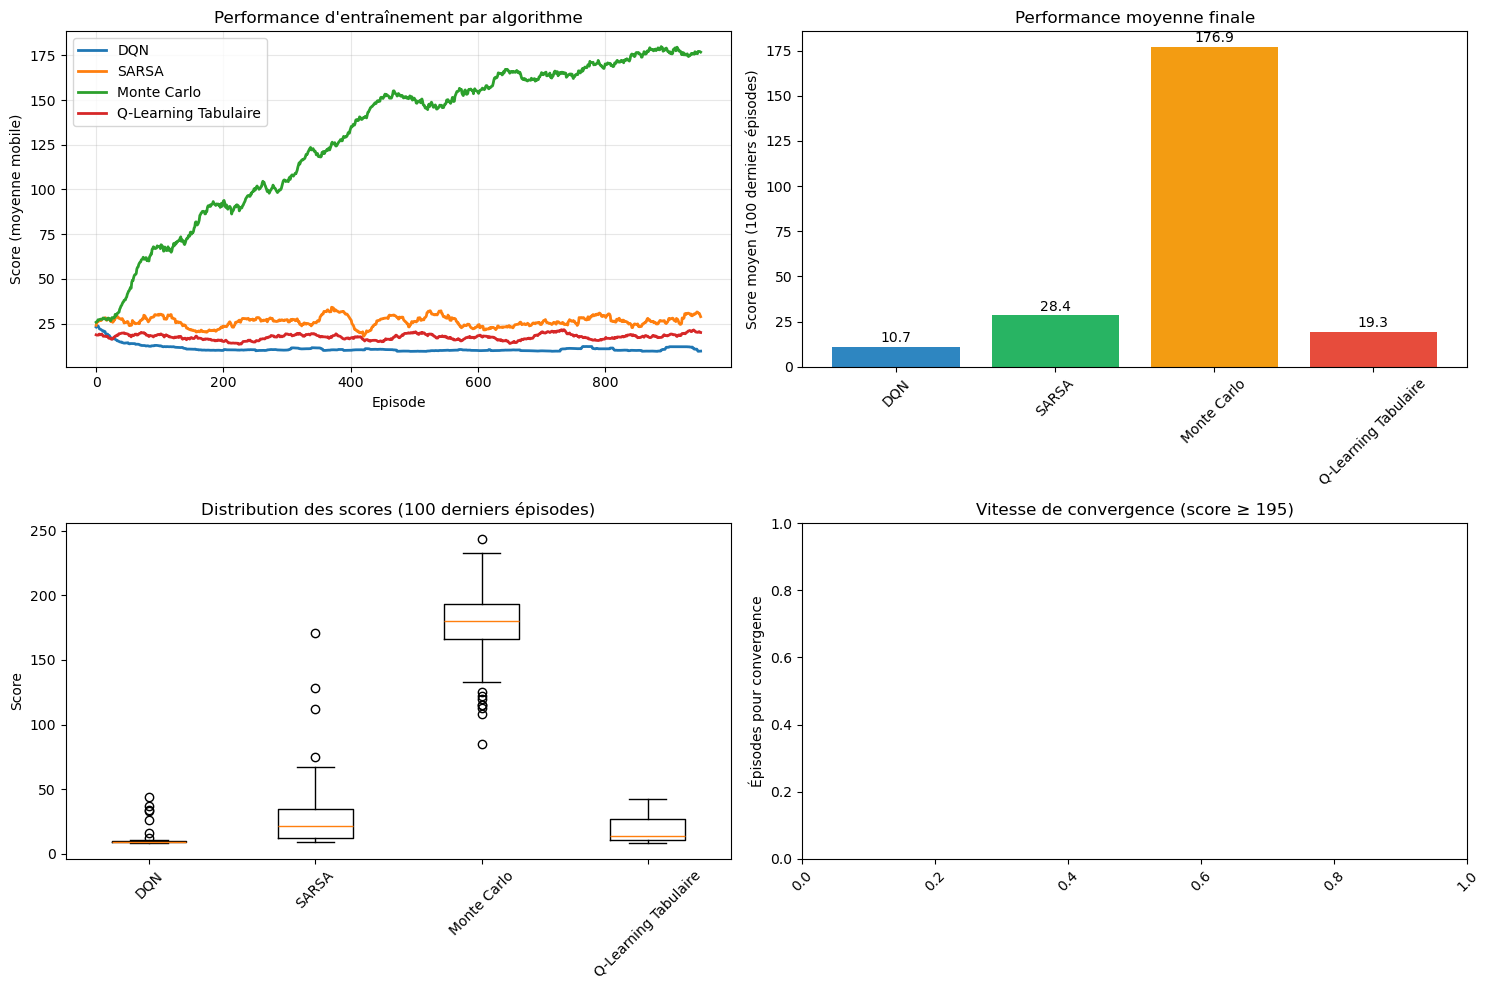


 RÉSUMÉ COMPARATIF DÉTAILLÉ

 DQN:
   Score moyen final: 10.74
   Écart-type: 5.78
   Score maximum: 44
   Taux de succès (≥200): 0.0%
   Convergence: Non atteinte

 SARSA:
   Score moyen final: 28.42
   Écart-type: 25.16
   Score maximum: 171
   Taux de succès (≥200): 0.0%
   Convergence: Non atteinte

 Monte Carlo:
   Score moyen final: 176.87
   Écart-type: 27.84
   Score maximum: 244
   Taux de succès (≥200): 17.0%
   Convergence: Non atteinte

 Q-Learning Tabulaire:
   Score moyen final: 19.30
   Écart-type: 10.50
   Score maximum: 42
   Taux de succès (≥200): 0.0%
   Convergence: Non atteinte

📋 TABLEAU RÉCAPITULATIF
Agent                Score Moyen  Écart-type  Score Max  Succès %  Convergence 
--------------------------------------------------------------------------------
DQN                  10.74        5.78        44         0.0       N/A         
SARSA                28.42        25.16       171        0.0       N/A         
Monte Carlo          176.87       27.84       2

In [11]:
# Visualiser les résultats d'entraînement
print("Génération des graphiques de performance...")
plot_training_results(results)

# Statistiques détaillées
print("\n" + "="*60)
print(" RÉSUMÉ COMPARATIF DÉTAILLÉ")
print("="*60)

performance_summary = []

for agent_name, scores in results.items():
    final_scores = scores[-100:]  # 100 derniers épisodes
    mean_score = np.mean(final_scores)
    std_score = np.std(final_scores)
    max_score = np.max(final_scores)
    success_rate = np.mean(np.array(final_scores) >= 200) * 100
    
    # Trouver l'épisode de convergence
    window_size = 100
    convergence_episode = None
    for i in range(window_size, len(scores)):
        if np.mean(scores[i-window_size:i]) >= 195:
            convergence_episode = i
            break
    
    performance_summary.append({
        'Agent': agent_name,
        'Score Moyen': mean_score,
        'Écart-type': std_score,
        'Score Max': max_score,
        'Taux de Succès (%)': success_rate,
        'Convergence': convergence_episode if convergence_episode else 'Non atteinte'
    })
    
    print(f"\n {agent_name}:")
    print(f"   Score moyen final: {mean_score:.2f}")
    print(f"   Écart-type: {std_score:.2f}")
    print(f"   Score maximum: {max_score:.0f}")
    print(f"   Taux de succès (≥200): {success_rate:.1f}%")
    print(f"   Convergence: {'Épisode ' + str(convergence_episode) if convergence_episode else 'Non atteinte'}")

# Créer un tableau récapitulatif
print(f"\n{'='*80}")
print("📋 TABLEAU RÉCAPITULATIF")
print(f"{'='*80}")
print(f"{'Agent':<20} {'Score Moyen':<12} {'Écart-type':<11} {'Score Max':<10} {'Succès %':<9} {'Convergence':<12}")
print("-" * 80)

for summary in performance_summary:
    conv_str = str(summary['Convergence']) if summary['Convergence'] != 'Non atteinte' else 'N/A'
    print(f"{summary['Agent']:<20} {summary['Score Moyen']:<12.2f} {summary['Écart-type']:<11.2f} "
          f"{summary['Score Max']:<10.0f} {summary['Taux de Succès (%)']:<9.1f} {conv_str:<12}")

print("\n🏅 Classement par performance moyenne:")
sorted_agents = sorted(performance_summary, key=lambda x: x['Score Moyen'], reverse=True)
for i, agent_data in enumerate(sorted_agents, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {medal} {agent_data['Agent']}: {agent_data['Score Moyen']:.2f}")

env.close()

# Cellule 11: Visualisation des Agents Entraînés

 DÉMONSTRATION DES AGENTS ENTRAÎNÉS
 Meilleur agent: Monte Carlo
 Score moyen: 176.87

Démonstration de Monte Carlo ENTRAÎNÉ:


/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mouhamed-sarr/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


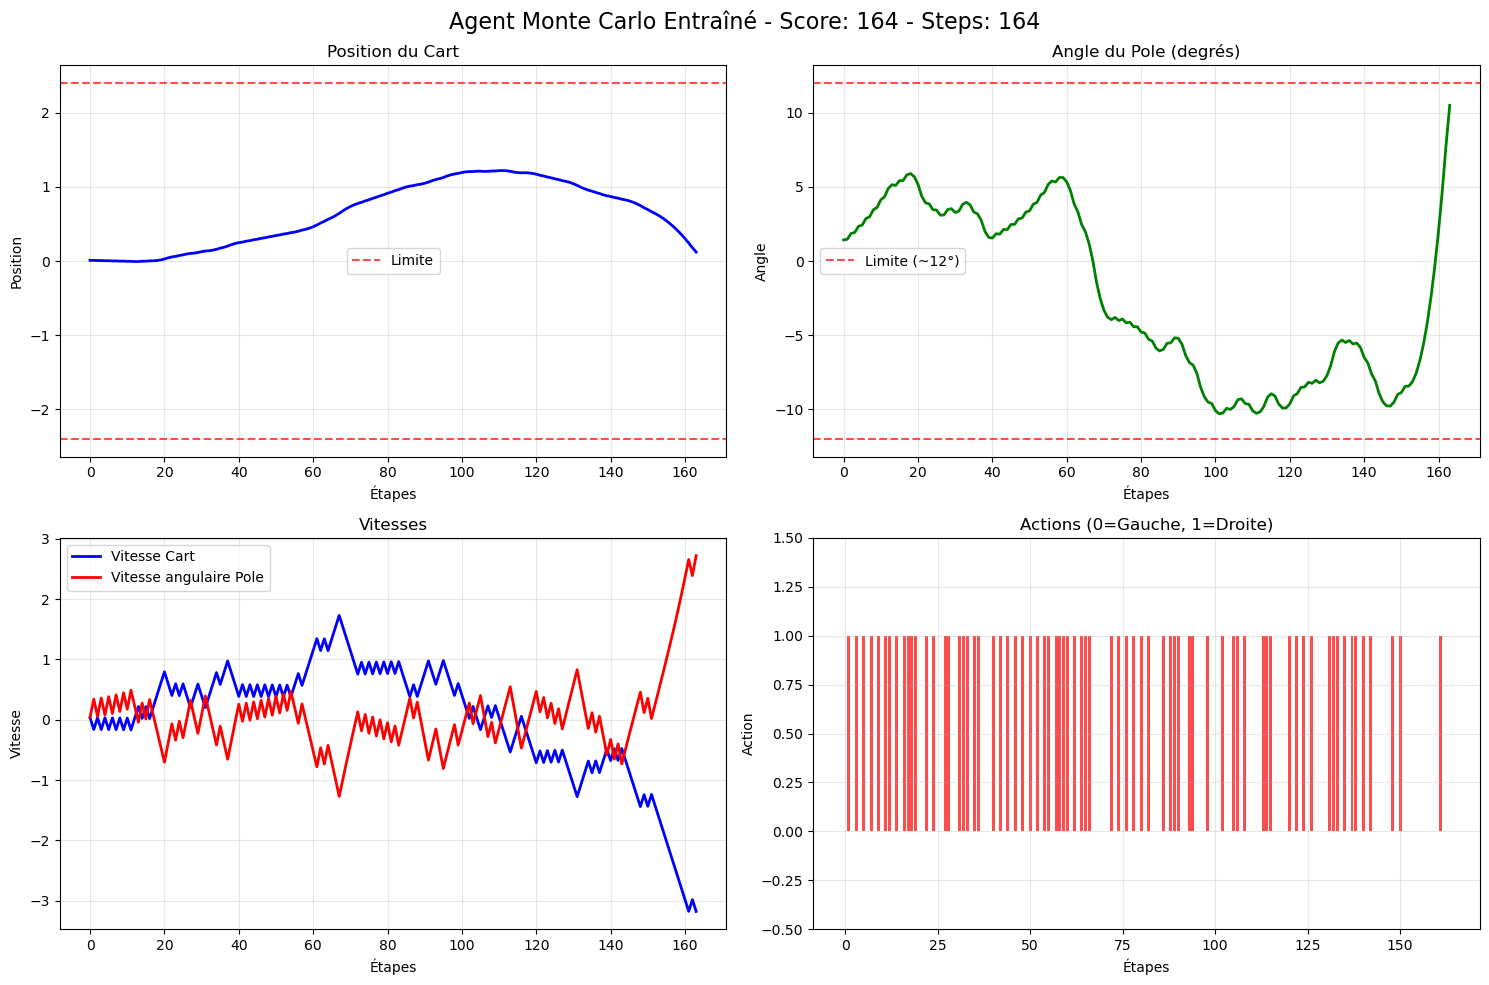


 Performance après entraînement (Monte Carlo):
   Score: 164.0
   Nombre d'étapes: 164
   Amélioration: +154 points

Création de l'animation de Monte Carlo entraîné...


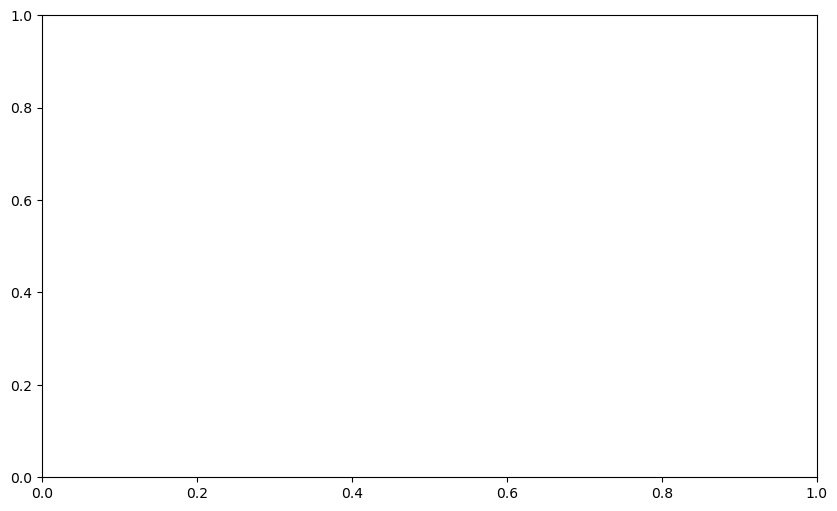

In [12]:
# Recréer l'environnement pour la visualisation
env = gym.make('CartPole-v1', render_mode='rgb_array')

print(" DÉMONSTRATION DES AGENTS ENTRAÎNÉS")
print("="*50)

# Choisir le meilleur agent pour la démonstration
best_agent_name = max(results.keys(), key=lambda name: np.mean(results[name][-100:]))
best_agent = agents[best_agent_name]

print(f" Meilleur agent: {best_agent_name}")
print(f" Score moyen: {np.mean(results[best_agent_name][-100:]):.2f}")
print()

# Visualiser la performance du meilleur agent
print(f"Démonstration de {best_agent_name} ENTRAÎNÉ:")
score_after, steps_after = visualize_cartpole_episode(
    best_agent, env, 
    title=f"Agent {best_agent_name} Entraîné"
)

print(f"\n Performance après entraînement ({best_agent_name}):")
print(f"   Score: {score_after}")
print(f"   Nombre d'étapes: {steps_after}")
print(f"   Amélioration: +{score_after - score_before:.0f} points")

# Animation du meilleur agent entraîné
print(f"\nCréation de l'animation de {best_agent_name} entraîné...")
anim_after, _, _ = create_cartpole_animation(
    best_agent, env, 
    title=f"Agent {best_agent_name} Entraîné", 
    max_steps=500
)

env.close()

# Cellule 12: Comparaison Avant/Après pour Tous les Agents

 COMPARAISON AVANT/APRÈS POUR TOUS LES AGENTS

 Test de DQN...
    Avant entraînement: 9.1
    Après entraînement: 9.5
    Amélioration: +0.4 (4%)

 Test de SARSA...
    Avant entraînement: 9.2
    Après entraînement: 29.0
    Amélioration: +19.8 (215%)

 Test de Monte Carlo...
    Avant entraînement: 9.7
    Après entraînement: 166.7
    Amélioration: +157.0 (1619%)

 Test de Q-Learning Tabulaire...
    Avant entraînement: 9.5
    Après entraînement: 15.4
    Amélioration: +5.9 (62%)


/tmp/ipykernel_16650/2554949911.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(agent_names, rotation=45)


<Figure size 1200x800 with 0 Axes>

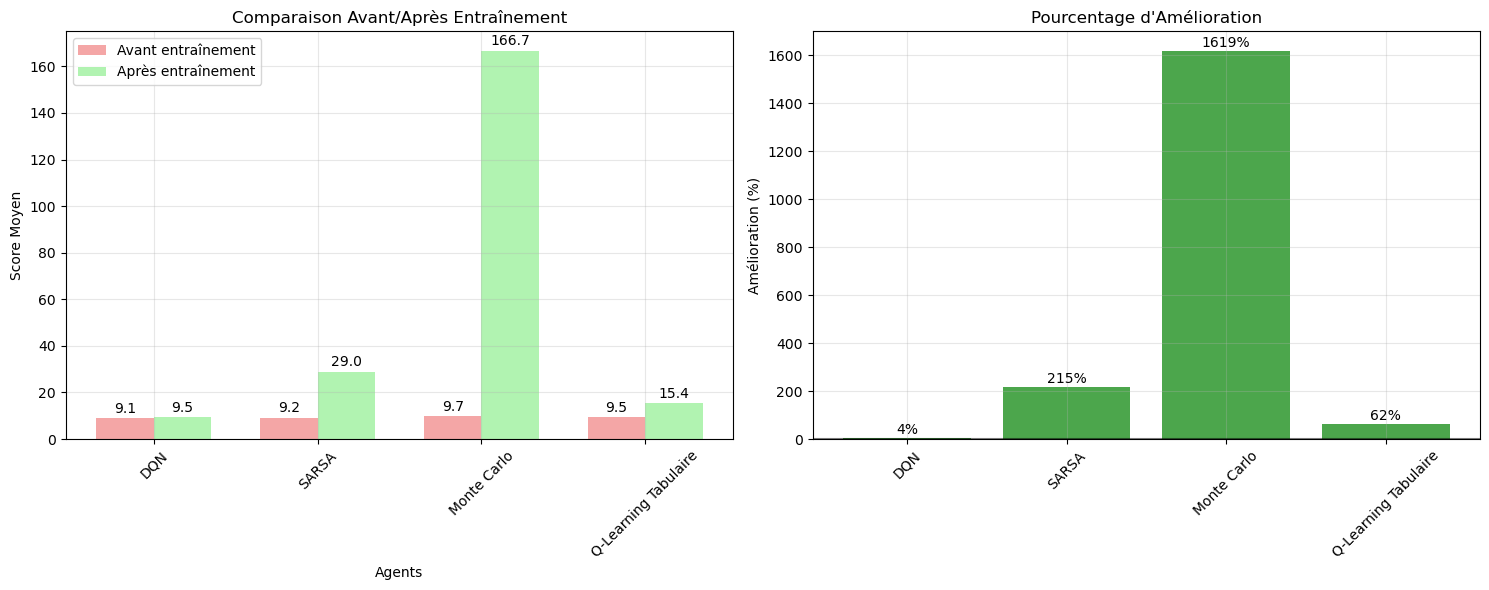


🏆 CLASSEMENT PAR AMÉLIORATION:
   🥇 Monte Carlo: +157.0 points (1619%)
   🥈 SARSA: +19.8 points (215%)
   🥉 Q-Learning Tabulaire: +5.9 points (62%)
   4. DQN: +0.4 points (4%)


In [13]:
def compare_all_agents():
    """Compare tous les agents avant et après entraînement"""
    
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    
    print(" COMPARAISON AVANT/APRÈS POUR TOUS LES AGENTS")
    print("="*60)
    
    comparison_results = {}
    
    for agent_name, trained_agent in agents.items():
        print(f"\n Test de {agent_name}...")
        
        # Créer un nouvel agent non-entraîné pour comparaison
        if agent_name == 'DQN':
            untrained = DQNAgent(state_size, action_size)
        elif agent_name == 'SARSA':
            untrained = SARSAAgent(state_size, action_size)
        elif agent_name == 'Monte Carlo':
            untrained = MonteCarloAgent(state_size, action_size)
        elif agent_name == 'Policy Gradient':
            untrained = PolicyGradientAgent(state_size, action_size)
        elif agent_name == 'Q-Learning Tabulaire':
            untrained = TabularQAgent(state_size, action_size)
        
        # Tester l'agent non-entraîné
        untrained_scores = evaluate_agent(untrained, env, episodes=10)
        untrained_mean = np.mean(untrained_scores)
        
        # Tester l'agent entraîné
        trained_scores = evaluate_agent(trained_agent, env, episodes=10)
        trained_mean = np.mean(trained_scores)
        
        improvement = trained_mean - untrained_mean
        improvement_percent = (improvement / untrained_mean) * 100 if untrained_mean > 0 else float('inf')
        
        comparison_results[agent_name] = {
            'avant': untrained_mean,
            'après': trained_mean,
            'amélioration': improvement,
            'amélioration_%': improvement_percent
        }
        
        print(f"    Avant entraînement: {untrained_mean:.1f}")
        print(f"    Après entraînement: {trained_mean:.1f}")
        print(f"    Amélioration: +{improvement:.1f} ({improvement_percent:.0f}%)")
    
    # Résumé graphique
    plt.figure(figsize=(12, 8))
    
    # Graphique de comparaison
    agent_names = list(comparison_results.keys())
    before_scores = [comparison_results[name]['avant'] for name in agent_names]
    after_scores = [comparison_results[name]['après'] for name in agent_names]
    
    x = np.arange(len(agent_names))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1: Comparaison avant/après
    bars1 = ax1.bar(x - width/2, before_scores, width, label='Avant entraînement', alpha=0.7, color='lightcoral')
    bars2 = ax1.bar(x + width/2, after_scores, width, label='Après entraînement', alpha=0.7, color='lightgreen')
    
    ax1.set_xlabel('Agents')
    ax1.set_ylabel('Score Moyen')
    ax1.set_title('Comparaison Avant/Après Entraînement')
    ax1.set_xticks(x)
    ax1.set_xticklabels(agent_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}', ha='center', va='bottom')
    
    # Graphique 2: Pourcentage d'amélioration
    improvements = [comparison_results[name]['amélioration_%'] for name in agent_names]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    
    bars3 = ax2.bar(agent_names, improvements, color=colors, alpha=0.7)
    ax2.set_ylabel('Amélioration (%)')
    ax2.set_title('Pourcentage d\'Amélioration')
    ax2.set_xticklabels(agent_names, rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Ajouter les valeurs sur les barres
    for bar, imp in zip(bars3, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -15),
                f'{imp:.0f}%', ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Classement par amélioration
    print(f"\n🏆 CLASSEMENT PAR AMÉLIORATION:")
    sorted_by_improvement = sorted(comparison_results.items(), 
                                 key=lambda x: x[1]['amélioration'], reverse=True)
    
    for i, (name, data) in enumerate(sorted_by_improvement, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        print(f"   {medal} {name}: +{data['amélioration']:.1f} points ({data['amélioration_%']:.0f}%)")
    
    env.close()
    return comparison_results

# Exécuter la comparaison
comparison_data = compare_all_agents()